# 编程练习4：神经网络学习
这次还是解决手写数字识别的问题。ex3中我们使用了已经训练好的神经网络，得到了比逻辑回归更好的效果。ex4我们自己来训练神经网络。
## 1 神经网络
### 1.1 数据可视化
这部分ex3已做过。唯一需要注意的，是将y用one-hot编码时，pandas的get_dummies函数的使用。具体说明见http://blog.csdn.net/mvpboss1004/article/details/79188190

In [2]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from random import sample
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
from operator import mul, add
from functools import reduce

In [3]:
raw_data = loadmat('ex4data1.mat')
X = np.mat(raw_data['X'])
y = np.mat(pd.get_dummies(raw_data['y'].flatten())).astype(np.float)
raw_theta = loadmat('ex4weights.mat')
Theta1 = raw_theta['Theta1']
Theta2 = raw_theta['Theta2']
m = len(y)

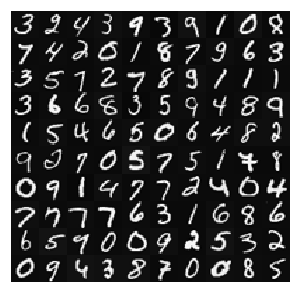

In [4]:
fig = plt.figure(figsize=(5,5))
sample_num = 100
idx = sample(range(0,m), sample_num)
for i in range(0, sample_num):
    plt.subplot(10, 10, i+1)
    plt.imshow(X[idx[i],:].reshape((20,20)).T, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 1.3 前向传播及代价函数
神经网络代价函数表示为：  
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$  
这里y是一个one-hot的矩阵，因此$h_\theta(X)$和y都是m*K的。我们可以用矩阵表示为：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]$$
注意，这里点乘表示对应元素相乘

In [5]:
def cost(thetas, *args):
    a, y, shapes = args
    start = 0
    for shape in shapes:
        size = reduce(mul, shape, 1)
        theta = np.mat(thetas[start:start+size]).reshape(shape)
        start += size
        a = np.column_stack([np.ones((len(a),1)), a])
        z = a * theta.T
        a = expit(z)
    J = np.sum(np.multiply(-y, np.log(a)) - np.multiply(1-y, np.log(1-a))) / len(y)
    return J
thetas = reduce(add, [Theta1.flatten().tolist(),Theta2.flatten().tolist()], []) 
shapes = [Theta1.shape, Theta2.shape]
print('Cost: %s\tExpected: 0.287629' % cost(thetas, X, y, shapes))

Cost: 0.2876291651613189	Expected: 0.287629


### 1.4 正则化代价函数
有了之前的基础，我们可以很快写出矩阵形式表示的正则化代价函数：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]+\frac{\lambda}{2m}\Theta^{*T}\Theta^{*}$$
注意，这里的$\Theta^*$，是把每一层的theta的偏置项置0。

In [6]:
def costReg(thetas, *args):
    X, y, shapes, lamda = args
    Thetas = np.mat(thetas)
    idx = 0
    for shape in shapes:
        for i in range(0,shape[0]):
            Thetas[0,idx] = 0
            idx += shape[1]
    J = cost(thetas, X, y, shapes) + lamda/(2*len(y))*Thetas*Thetas.T
    return J[0,0]
lamda = 1
print('Cost: %s\tExpected: 0.383770' % costReg(thetas, X, y, shapes, lamda))

Cost: 0.38376985909092365	Expected: 0.383770


## 2 反向传播
这里其实还是用梯度下降法求解。只要能将梯度表示出来，就能求解。这个和之前的思路是一样的。
### 2.1 Sigmoid函数梯度

In [12]:
def sigmoidGradient(z):
    return np.multiply(expit(z), 1-expit(z))
print("g'(0): %s\tExpectec: 0.25" % sigmoidGradient(0))

g'(0): 0.25	Expectec: 0.25


### 2.2 随机初始化

In [10]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = np.sqrt(6.0 / (L_in+L_out))
    return np.random.rand(L_out, 1+L_in)*2*epsilon_init - epsilon_init
print(randInitializeWeights(400,10))

[[ 0.0833745   0.08637982 -0.05900984 ... -0.02628206  0.095095
  -0.02951599]
 [-0.05792362  0.03083186 -0.10935672 ... -0.03582645  0.11669994
   0.02013944]
 [-0.10356214 -0.10203289  0.09119987 ...  0.10209065 -0.02381409
   0.10281735]
 ...
 [-0.06968584  0.02921845 -0.0998224  ...  0.00808864  0.08350187
  -0.07786839]
 [-0.09260055 -0.04705008 -0.0363085  ... -0.07040697 -0.04554099
  -0.11579959]
 [-0.00488057  0.05211424  0.09445966 ... -0.10442074 -0.12082356
  -0.0173197 ]]


### 2.3 反向传播